In [1]:
from requests import get
wiki = get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

In [2]:
from bs4 import BeautifulSoup as soup
parsed_wiki = soup(wiki.text, "lxml")
table_rows = parsed_wiki.body.table.tbody.find_all("tr")

In [4]:
import pandas as pd
postal_code_df = pd.read_html(wiki.text, na_values=["Not assigned"])
postal_code_df = postal_code_df[0]
postal_code_df2 = postal_code_df.drop([0], axis=0)
postal_code_df2.columns = ["Postcode", "Borough", "Neighbourhood"]
postal_code_df2.head(10)

,Postcode,Borough,Neighbourhood
1,M1A,NaN,NaN
2,M2A,NaN,NaN
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,NaN
10,M8A,NaN,NaN


In [6]:
postal_code_df2["Neighbourhood"].fillna(value=postal_code_df2["Borough"], inplace=True)
postal_code_df2.head(10)

,Postcode,Borough,Neighbourhood
1,M1A,NaN,NaN
2,M2A,NaN,NaN
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Queen's Park
10,M8A,NaN,NaN


In [7]:
postal_code_df2.dropna(inplace=True)
postal_code_df2.head(10)

,Postcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Queen's Park
11,M9A,Etobicoke,Islington Avenue
12,M1B,Scarborough,Rouge
13,M1B,Scarborough,Malvern


In [8]:
grouped_df = postal_code_df2.groupby(["Postcode", "Borough"]).aggregate(", ".join).reset_index()
grouped_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [9]:
grouped_df.shape

(103, 3)

In [10]:
import geocoder

def get_geo_coordinates(postal_code):
    print("Looking up latitude and longitude of: {}".format(postal_code))
    lat_lng_coords = None

    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng
    return (lat_lng_coords[0], lat_lng_coords[1])

In [11]:
geospatial_coord_df = pd.read_csv("https://cocl.us/Geospatial_data")
grouped_df["Postal Code"] = grouped_df["Postcode"]
grouped_df.drop("Postcode",axis=1, inplace=True)

In [12]:
postal_code_with_coords_df = grouped_df.merge(geospatial_coord_df, on="Postal Code")
postal_code_with_coords_df.head(10)

,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,Scarborough,Woburn,M1G,43.770992,-79.216917
4,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",M1K,43.727929,-79.262029
7,Scarborough,"Clairlea, Golden Mile, Oakridge",M1L,43.711112,-79.284577
8,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",M1M,43.716316,-79.239476
9,Scarborough,"Birch Cliff, Cliffside West",M1N,43.692657,-79.264848


In [15]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import numpy as np

In [16]:
def get_weighted_inertia(num_clusters, X):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
    return (1.75 ** num_clusters) * kmeans.inertia_

In [17]:
num_cluster_candidates = list(range(2, 21))
boroughs_with_coords_df = postal_code_with_coords_df.drop(["Postal Code","Neighbourhood"], axis=1)
boroughs_with_coords_df = pd.get_dummies(boroughs_with_coords_df).reset_index().drop("index", axis=1)
boroughs_with_coords_df.columns

Index(['Latitude', 'Longitude', 'Borough_Central Toronto',
       'Borough_Downtown Toronto', 'Borough_East Toronto', 'Borough_East York',
       'Borough_Etobicoke', 'Borough_Mississauga', 'Borough_North York',
       'Borough_Queen's Park', 'Borough_Scarborough', 'Borough_West Toronto',
       'Borough_York'],
      dtype='object')

In [18]:
weighted_inertias = [get_weighted_inertia(num_cluster, boroughs_with_coords_df) for num_cluster in num_cluster_candidates]
best_weighted_inertia_k = num_cluster_candidates[np.argmin(weighted_inertias)]
best_weighted_inertia_k

11

In [19]:
kmeans = KMeans(n_clusters=best_weighted_inertia_k, random_state=0).fit(boroughs_with_coords_df)
postal_code_with_coords_df.insert(0, 'Cluster Labels', kmeans.labels_)
postal_code_with_coords_df.head(10)

,Cluster Labels,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,3,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,3,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,3,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,3,Scarborough,Woburn,M1G,43.770992,-79.216917
4,3,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,3,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,3,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",M1K,43.727929,-79.262029
7,3,Scarborough,"Clairlea, Golden Mile, Oakridge",M1L,43.711112,-79.284577
8,3,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",M1M,43.716316,-79.239476
9,3,Scarborough,"Birch Cliff, Cliffside West",M1N,43.692657,-79.264848


In [20]:
avg_latitude_longitude = postal_code_with_coords_df[["Latitude", "Longitude"]].mean(axis=0)
avg_latitude_longitude
latitude, longitude = avg_latitude_longitude["Latitude"], avg_latitude_longitude["Longitude"]

In [21]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(best_weighted_inertia_k)
ys = [i + x + (i*x)**2 for i in range(best_weighted_inertia_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, bur, cluster in zip(postal_code_with_coords_df['Latitude'], postal_code_with_coords_df['Longitude'], postal_code_with_coords_df['Borough'], postal_code_with_coords_df['Cluster Labels']):
    label = folium.Popup(str(bur) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Populating the interactive namespace from numpy and matplotlib


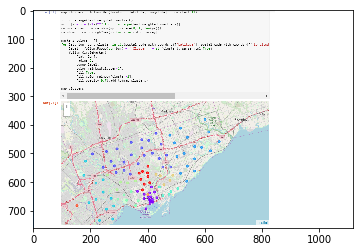

In [29]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('Toronto Segmentation Map.png')
imgplot = plt.imshow(img)
plt.show()

# Because Github cannot show a map picture
# So I show the result using plt